## SEIR Model

Based on http://gabgoh.github.io/COVID/index.html, with modifications

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
import datetime
from functools import partial

import ipywidgets as widgets
import numpy as np
import pandas as pd
from pandas.testing import assert_series_equal

from seir import Seir

In [2]:
# Calibration: Alternating regimes of exposure and social distancing (see r_0_values)

# Note:
# - Hospitalisation rate is assumed to be p_severe + p_fatal = 20%
# - We might need to modify the model further to differentiate between hospitalised
# cases (here 20%) and the much smaller subset of ICU cases. A quick hack could be
# to just multiply 'I_severe_hospital' by a conditional ICU fraction we find in the
# literature, to then add all of 'I_fatal_hospital', and to call this time series ICUs
r0_steps = [
    ("2020-02-28", 3.5),
    ("2020-03-20", 1.25),
    ("2020-04-20", 2.5),
    ("2020-06-30", 3.5),
    ("2020-09-30", 3.5),
]

parameters = {
    "r_0_days": [21, 42, 63, 100],  # note: the last entry has to equal 'periods'
    "r_0_values": [3.5, 1.25, 2.5, 1.25],
    "t_infectious": 2.9,
    "t_incubation": 5.2,
    "p_severe": 0.18,
    "p_fatal": 0.02,
    "t_recovery_mild": 15 - 2.9,
    "t_recovery_severe": 31.5 - 2.9,
    "t_hospital_lag": 5,
    "t_death": 32 - 2.9,
    "icu_fraction": 0.5,  # share of severe hospital cases that needs ICU
}

N = 10000
start = {
    "S": 1.0 - 1 / N,
    "E": 1.0 / N,
    "I": 0.0,
    "I_mild": 0.0,
    "I_severe_home": 0.0,
    "I_severe_hospital": 0.0,
    "I_fatal_home": 0.0,
    "I_fatal_hospital": 0.0,
    "R_from_mild": 0.0,
    "R_from_severe": 0.0,
    "Dead": 0,
}

In [3]:
seir = Seir(params=parameters, start=start, dT=0.1)
seir.simulate(r0_steps)

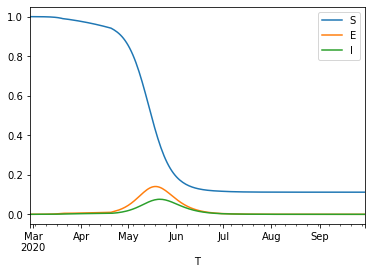

In [4]:
seir.data[["S", "E", "I"]].plot()

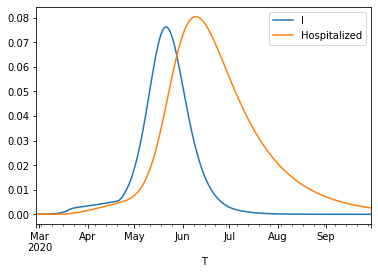

In [5]:
seir.data[["I", "Hospitalized"]].plot()

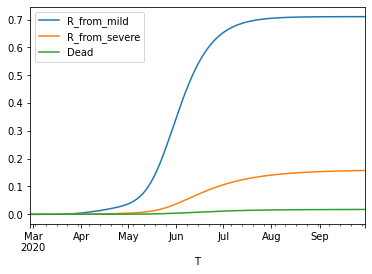

In [6]:
seir.data[["R_from_mild", "R_from_severe", "Dead"]].plot()

## Allow for changes in Path

In [7]:
def r0_steps_from_widget(
    r0_baseline, r0_lockdown, r0_relaxation, date_of_relaxation, duration_of_relaxation
):
    period_baseline = ("2020-02-01", r0_baseline)
    period_lockdown = ("2020-03-20", r0_lockdown)
    period_relax = (str(date_of_relaxation), r0_relaxation)
    date_normal = str(
        date_of_relaxation + datetime.timedelta(days=duration_of_relaxation)
    )
    period_normal = (date_normal, r0_baseline)
    r0_steps = [period_baseline, period_lockdown, period_relax, period_normal]
    return r0_steps


def update_results(
    start,
    params,
    r0_baseline,
    r0_lockdown,
    r0_relaxation,
    date_of_relaxation,
    duration_of_relaxation,
):

    r0_steps = r0_steps_from_widget(
        r0_baseline,
        r0_lockdown,
        r0_relaxation,
        date_of_relaxation,
        duration_of_relaxation,
    )

    seir = Seir(params=params, start=start)
    seir.simulate(r0_steps)
    seir.data[["I_severe_hospital", "I_fatal_hospital", "R_from_severe", "Dead"]].plot()
    return None


update_results_partial = partial(update_results, start=start, params=parameters)


def date_widget(description, starting_date, length, initial_value):
    starting_date = datetime.date.fromisoformat(starting_date)
    initial_value = datetime.date.fromisoformat(initial_value)
    date_range = [starting_date + datetime.timedelta(days=d) for d in range(length)]
    w = widgets.SelectionSlider(
        options=date_range,
        value=initial_value,
        description="Lockdown",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
    )
    return w


def r0_widget(value=3.5, description="R0"):
    w = widgets.FloatSlider(
        value=value,
        min=0,
        max=5,
        step=0.1,
        description=description,
        continuous_update=False,
    )
    return w

In [8]:
# Policy path
r0_baseline = r0_widget(3.5, description="R0 in Baseline Period")
r0_lockdown = r0_widget(1.25, description="R0 in Lockdown Period")
r0_relaxation = r0_widget(1.75, description="R0 in Relaxation Period")
date_of_relaxation = date_widget("Relaxation 1", "2020-03-01", 60, "2020-03-20")
duration_of_relaxation = widgets.IntSlider(
    description="Duration of Relaxation Period", value=60, min=0, max=180
)

policy_box = widgets.VBox(
    [
        r0_baseline,
        r0_lockdown,
        r0_relaxation,
        date_of_relaxation,
        duration_of_relaxation,
    ]
)

# Parameters
parameters_box = widgets.VBox()

# Starting Values
start_box = widgets.VBox()

# Combine inputs in tabs
input_tab = widgets.Tab()
input_tab.children = [policy_box, parameters_box, start_box]
titles = ["Policy", "Parameters", "Starting Values"]
for i, x in enumerate(titles):
    input_tab.set_title(i, x)

# Output box
output_box = widgets.interactive_output(
    update_results_partial,
    {
        "r0_baseline": r0_baseline,
        "r0_lockdown": r0_lockdown,
        "r0_relaxation": r0_relaxation,
        "date_of_relaxation": date_of_relaxation,
        "duration_of_relaxation": duration_of_relaxation,
    },
)

# Combination
widgets.VBox([input_tab, output_box])